In [1]:
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14, "axes.labelpad": 10})

import seaborn as sns
from scipy.stats import variation

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('data/data_cleaned.csv', dtype={"gender": str})

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87814 entries, 0 to 87813
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject       87814 non-null  object 
 1   gender        51064 non-null  object 
 2   age           51064 non-null  float64
 3   hand          87814 non-null  object 
 4   x_coordinate  87814 non-null  int64  
 5   y_coordinate  87814 non-null  int64  
 6   timestamp     87814 non-null  int64  
 7   state         87814 non-null  int64  
 8   date          87814 non-null  object 
 9   azimuth       87814 non-null  int64  
 10  altitude      87814 non-null  int64  
 11  pressure      87814 non-null  int64  
 12  control       87814 non-null  object 
 13  session       87814 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 9.4+ MB


In [4]:
df.describe()

,age,x_coordinate,y_coordinate,timestamp,state,azimuth,altitude,pressure
count,51064.000000,87814.000000,87814.000000,8.781400e+04,87814.000000,87814.000000,87814.000000,87814.000000
mean,42.697164,4976.613911,6055.962899,1.810011e+11,0.948596,1341.180905,751.613980,1188.174403
std,13.403940,1148.082958,2762.429397,4.601096e+11,0.220822,1120.500856,100.263892,462.840822
min,22.000000,516.000000,1495.000000,2.108900e+05,0.000000,0.000000,270.000000,0.000000
25%,32.000000,4610.000000,3301.000000,2.111784e+06,1.000000,180.000000,710.000000,987.000000
50%,48.000000,5177.000000,6970.000000,2.909020e+06,1.000000,1530.000000,760.000000,1229.000000
75%,52.000000,5685.000000,8396.000000,1.080945e+07,1.000000,1940.000000,810.000000,1459.000000
max,62.000000,6760.000000,12317.000000,1.351607e+12,1.000000,3590.000000,900.000000,2048.000000


In [5]:
df.describe(include='O')

,subject,gender,hand,date,control,session
count,87814,51064,87814,87814,87814,87814
unique,23,2,2,87793,2,37
top,C10,F,R,2012-10-18 02:17:09.773000,Y,u00011s00001_hw00001.svc
freq,7438,37484,75200,2,51064,4890


In [6]:
def plot_spiral_session(df):
    subject = df.subject.unique()[0]
    session = df.session.unique()[0]
    fig, ax1 = plt.subplots(figsize=(7, 6))

    ax1.scatter(df["x_coordinate"], df["y_coordinate"], s=2)
    ax1.set_xlabel("X Coordinate", labelpad=10)
    ax1.set_ylabel("Y Coordinate", labelpad=10)

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

In [7]:
def plot_frequency_vs_speed_variability(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df,
        x="dominant_frequency",
        y="speed_variability",
        hue="control",
    )

    plt.xlabel("Dominant Frequency")
    plt.ylabel("Speed Variability")
    plt.grid(False)
    plt.show()

In [8]:
def plot_decision_boundary(X, y, model):
    plt.rcParams.update({"font.size": 20, "axes.labelpad": 10})
    x_min, x_max = (
        X["dominant_frequency"].min() - 0.5,
        X["dominant_frequency"].max() + 0.5,
    )
    y_min, y_max = (
        X["speed_variability"].min() - 0.1,
        X["speed_variability"].max() + 0.1,
    )
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlBu")
    scatter = plt.scatter(
        X["dominant_frequency"],
        X["speed_variability"],
        c=y,
        cmap="RdYlBu",
        edgecolor="black",
    )
    plt.xlabel("Dominant Frequency")
    plt.ylabel("Speed Variability")
    # plt.title("LDA Decision Boundary")
    plt.colorbar(scatter)
    plt.grid(False)
    plt.show()

In [9]:
def analyze_tremor_frequency(df):
    df = df.copy()

    df["dx"] = df["x_coordinate"].diff()
    df["dy"] = df["y_coordinate"].diff()
    df["distance"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

    df["dt"] = pd.to_datetime(df["date"]).diff().dt.total_seconds()

    df["speed"] = df["distance"] / df["dt"]

    speed_data = df["speed"].dropna().values

    N = len(speed_data)

    T = df["dt"].mean()

    yf = fft(speed_data)
    xf = fftfreq(N, T)[: N // 2]

    positive_freq = xf[1 : N // 2]
    magnitudes = 2.0 / N * np.abs(yf[1 : N // 2])

    min_freq = 1
    max_freq = 10
    mask = (positive_freq >= min_freq) & (positive_freq <= max_freq)
    dominant_freq = positive_freq[mask][np.argmax(magnitudes[mask])]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(positive_freq, magnitudes, color="blue", label="Frequency Spectrum")
    ax1.axvline(
        x=dominant_freq,
        color="red",
        linestyle="--",
        label=f"Dominant Frequency: {dominant_freq:.2f} Hz",
    )
    ax1.set_xlabel("Frequency (Hz)", labelpad=10)
    ax1.set_ylabel("Magnitude", labelpad=10)
    ax1.legend(frameon=False)

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

    return dominant_freq


In [10]:
def calculate_metrics(df):
    df = df.copy()
    df["dx"] = df["x_coordinate"].diff()
    df["dy"] = df["y_coordinate"].diff()
    df["distance"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)
    df["dt"] = pd.to_datetime(df["date"]).diff().dt.total_seconds()
    df["speed"] = df["distance"] / df["dt"]

    speed_data = df["speed"].dropna().values
    N = len(speed_data)
    T = df["dt"].mean()
    yf = fft(speed_data)
    xf = fftfreq(N, T)[: N // 2]

    positive_freq = xf[1 : N // 2]
    magnitudes = 2.0 / N * np.abs(yf[1 : N // 2])
    mask = (positive_freq >= 1) & (positive_freq <= 10)
    dominant_freq = positive_freq[mask][np.argmax(magnitudes[mask])]

    speed_cv = variation(df["speed"].dropna())

    return {
        "dominant_frequency": dominant_freq,
        "speed_variability": speed_cv,
    }

In [11]:
non_park_df = df[
    (df.subject == "C01") & (df.session == "u00003s00002_hw000011.svc")
].reset_index(drop=True)
park_df = df[
    (df.subject == "T001") & (df.session == "u00005s00001_hw00001.svc")
].reset_index(drop=True)

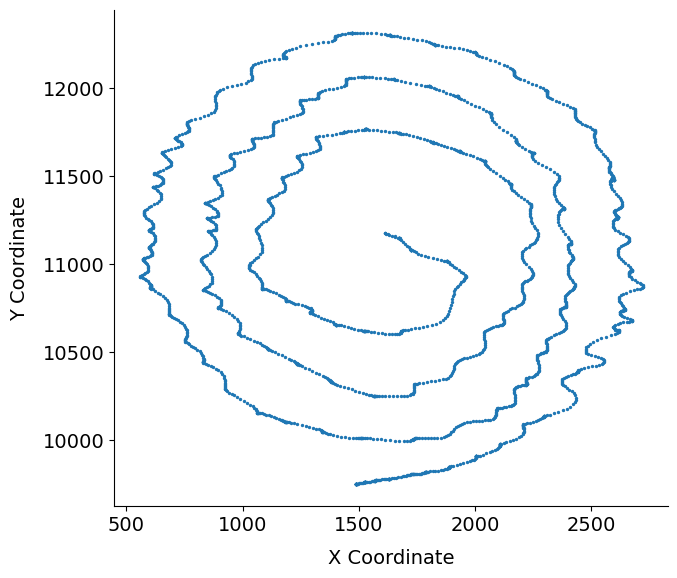

In [12]:
plot_spiral_session(park_df)

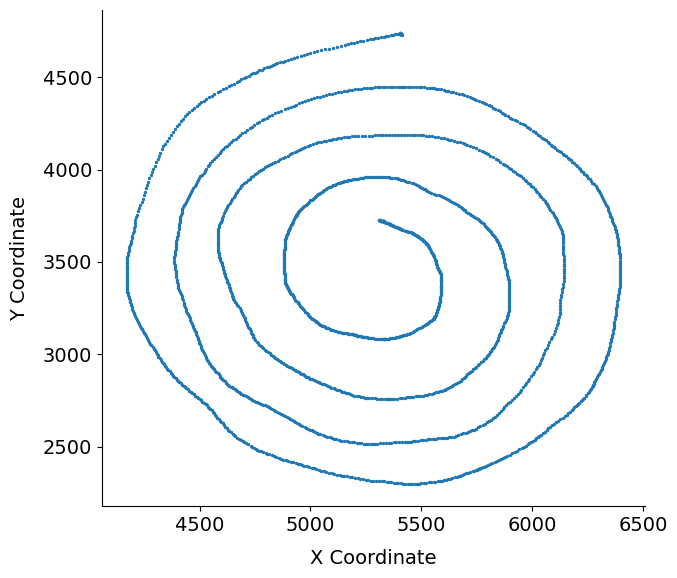

In [13]:
plot_spiral_session(non_park_df)

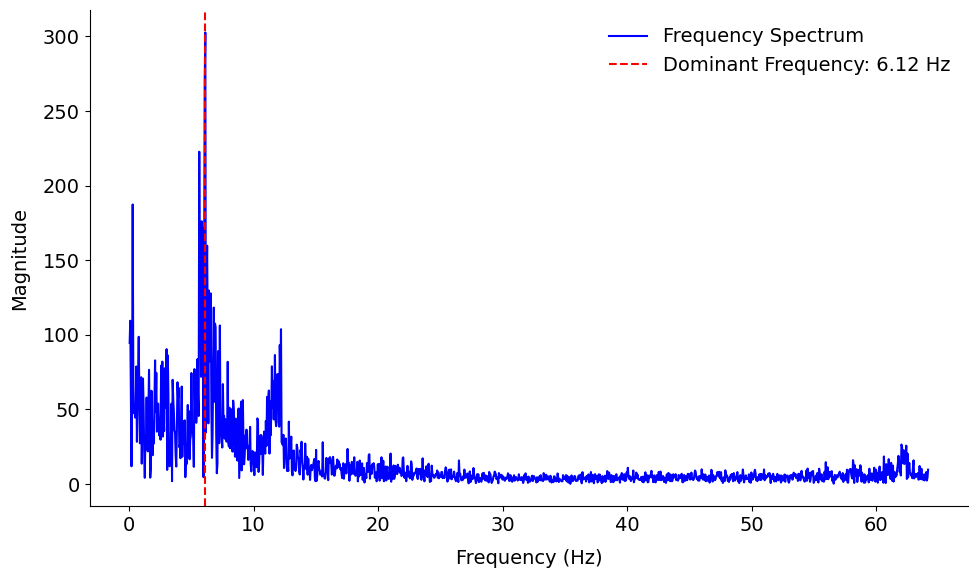

6.124829865837059

In [14]:
analyze_tremor_frequency(park_df)

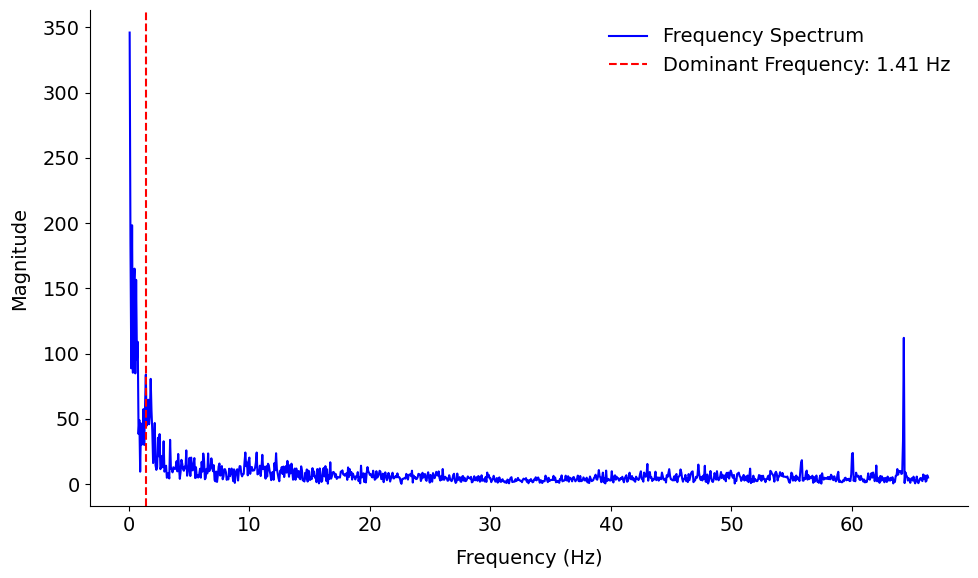

1.4096798013022749

In [15]:
analyze_tremor_frequency(non_park_df)

In [16]:
metrics_list = []
subjects = df.subject.unique()

for subject in subjects:
    subject_df = df[df.subject == subject]
    for session in subject_df.session.unique():
        session_df = subject_df[
            (subject_df.session == session) & (subject_df.subject == subject)
        ]
        metrics = calculate_metrics(session_df)
        metrics["subject"] = subject
        metrics["session"] = session
        metrics["control"] = session_df.control.unique()[0]
        metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)

In [17]:
metrics_df["control_numeric"] = (metrics_df["control"] == "N").astype(int)
metrics_df

,dominant_frequency,speed_variability,subject,session,control,control_numeric
0,1.099399,0.328152,C01,u00003s00002_hw000012.svc,Y,0
1,1.409680,0.355251,C01,u00003s00002_hw000011.svc,Y,0
2,2.187829,0.307090,C02,u00004s00001_hw000011.svc,Y,0
3,1.328357,0.384199,C02,u00004s00001_hw000012.svc,Y,0
4,1.125828,0.283591,C03,u00005s00001_hw000011.svc,Y,0
5,1.176401,0.371980,C03,u00005s00001_hw000012.svc,Y,0
6,1.262523,0.456325,C04,u00006s00001_hw000012.svc,Y,0
7,1.775761,0.461092,C04,u00006s00001_hw000011.svc,Y,0
8,3.246026,0.438721,C05,u00007s00001_hw000012.svc,Y,0
9,1.043612,0.524839,C05,u00007s00001_hw000011.svc,Y,0


In [18]:
metrics_df[metrics_df.control == "N"]

,dominant_frequency,speed_variability,subject,session,control,control_numeric
20,6.124830,0.732902,T001,u00005s00001_hw00001.svc,N,1
21,5.742626,1.275660,T001,u00005s00001_hw00002.svc,N,1
22,5.966151,0.859836,T005,u00009s00001_hw000011.svc,N,1
23,6.787475,0.588983,T005,u00009s00001_hw000012.svc,N,1
24,7.341164,1.757287,T006,u00010s00001_hw00002.svc,N,1
25,8.274816,1.144920,T006,u00010s00001_hw00001.svc,N,1
26,5.801142,1.688764,T007,u00012s00001_hw00002.svc,N,1
27,8.290524,1.418571,T007,u00012s00001_hw00001.svc,N,1
28,6.392376,1.952122,T008,u00013s00001_hw00002.svc,N,1
29,8.872269,1.487170,T009,u00014s00001_hw00001.svc,N,1


In [19]:
numeric_columns = metrics_df.select_dtypes(include=[np.number]).columns
control_group_means = metrics_df.groupby("control")[numeric_columns].mean()

print("Mean values for each metric by control group:")
control_group_means

Mean values for each metric by control group:


,dominant_frequency,speed_variability,control_numeric
control,,,
N,7.454386,1.195829,1.0
Y,1.625361,0.457326,0.0


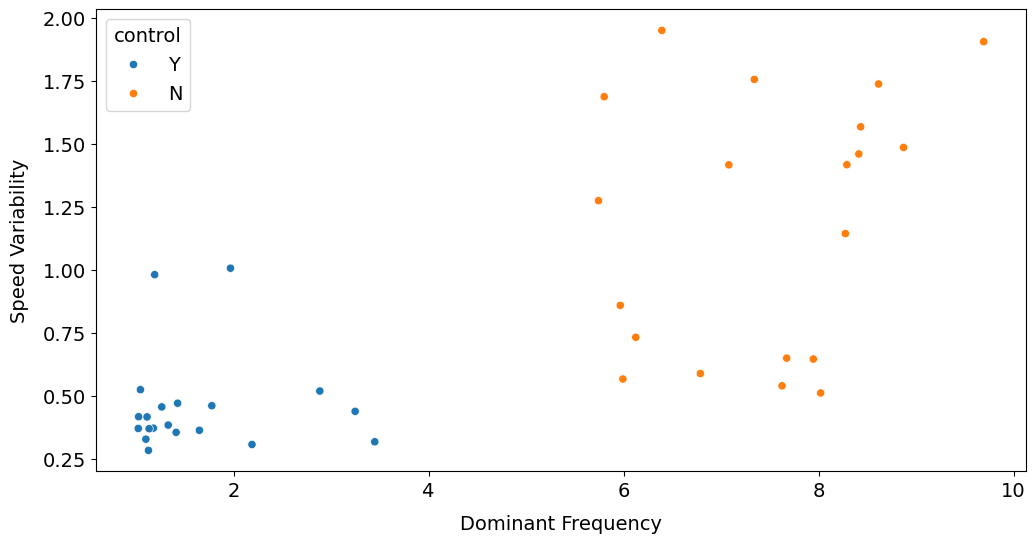

In [20]:
plot_frequency_vs_speed_variability(metrics_df)

In [21]:
X = metrics_df[["dominant_frequency"]]
y = metrics_df["control_numeric"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [23]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [24]:
y_pred = lda.predict(X_test)

In [25]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Control", "Control"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nLDA Coefficients:")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {lda.coef_[0][i]:.4f}")

Classification Report:
              precision    recall  f1-score   support

 Not Control       1.00      1.00      1.00         6
     Control       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


Confusion Matrix:
[[6 0]
 [0 6]]

LDA Coefficients:
dominant_frequency: 5.5817


In [26]:
X = metrics_df[["dominant_frequency", "speed_variability"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


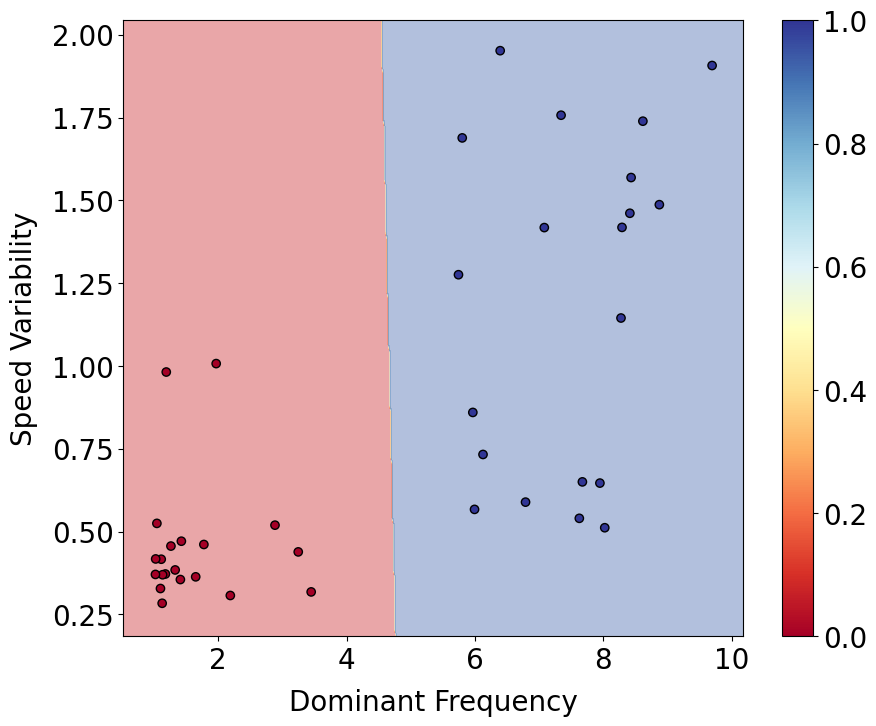

In [27]:
plot_decision_boundary(X, y, lda)

# Convolutional Neural Network

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold

import optuna

In [29]:
def create_spiral_image(group, size=(224, 224)):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(group["x_coordinate"], group["y_coordinate"], "k-", linewidth=2)
    ax.axis("off")
    ax.set_xlim(group["x_coordinate"].min(), group["x_coordinate"].max())
    ax.set_ylim(group["y_coordinate"].min(), group["y_coordinate"].max())

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    buf.seek(0)
    img = Image.open(buf)
    img = img.resize(size, Image.LANCZOS)
    plt.close(fig)
    return img

In [30]:
def generate_dataset_images(df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    grouped = df.groupby(["subject", "session"])

    for (subject, session), group in grouped:
        img = create_spiral_image(group)
        label = "Y" if group["control"].iloc[0] == "Y" else "N"
        img_name = f"spiral_{subject}_{session.replace('.svc','')}_label_{label}.png"
        img.save(os.path.join(output_dir, img_name))

In [31]:
spirals_images_path = "./spirals_images/"
generate_dataset_images(df, spirals_images_path)

In [32]:
class SpiralImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(".png")]
        self.labels = [1 if "label_Y" in f else 0 for f in self.images]
        self.subject_session = [(f.split("_")[1], f.split("_")[2]) for f in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        subject, session = self.subject_session[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, subject, session

In [33]:
class SpiralCNN(nn.Module):
    def __init__(self):
        super(SpiralCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(52 * 52 * 64, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [34]:
def train_model(model, train_loader, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels, _, _ in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.binary_cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

In [35]:
def validate_model(model, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _, _ in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = F.binary_cross_entropy(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

In [36]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [37]:
full_dataset = SpiralImageDataset(spirals_images_path, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


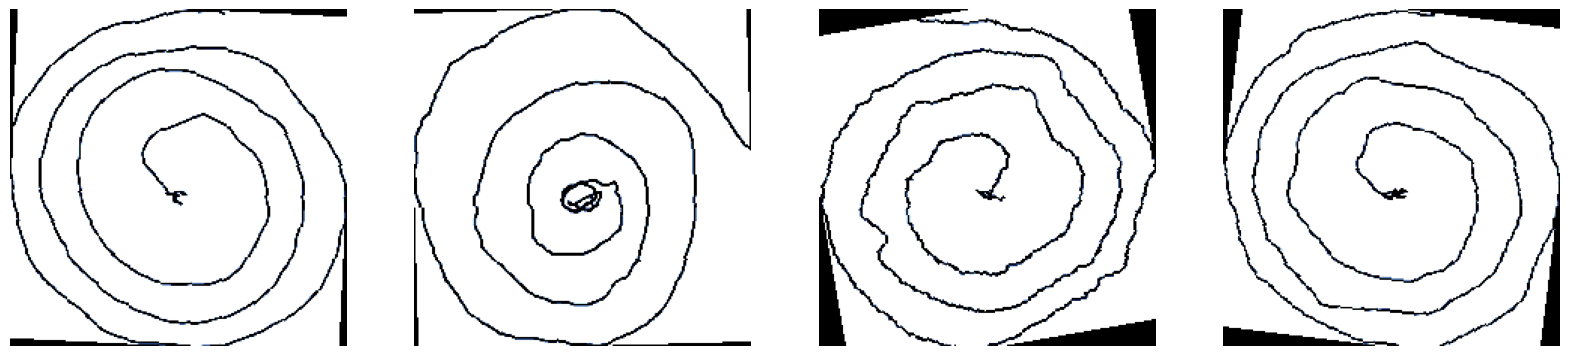

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    img, _, _, _ = full_dataset[i]
    img = img.permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

In [39]:
batch_size = 4
num_epochs = 50
k_folds = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

In [ ]:
for fold, (train_ids, val_ids) in enumerate(
    kfold.split(full_dataset, full_dataset.labels)
):
    print(f"FOLD {fold}")
    print("--------------------------------")

    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)

    train_loader = DataLoader(
        full_dataset, batch_size=batch_size, sampler=train_subsampler, drop_last=True
    )
    val_loader = DataLoader(
        full_dataset, batch_size=batch_size, sampler=val_subsampler, drop_last=True
    )

    model = SpiralCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, optimizer, device)
        val_loss, val_acc = validate_model(model, val_loader, device)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    torch.save(model.state_dict(), f"spiral_cnn_model_fold_{fold}.pth")
    
print("Cross-validation finished")

FOLD 0
--------------------------------
Epoch 1/50, Train Loss: 5.9099, Train Acc: 0.5000, Val Loss: 0.6798, Val Acc: 0.5000
Epoch 2/50, Train Loss: 0.8343, Train Acc: 0.4062, Val Loss: 0.6842, Val Acc: 0.5000
Epoch 3/50, Train Loss: 0.7070, Train Acc: 0.5000, Val Loss: 0.6917, Val Acc: 0.5000
Epoch 4/50, Train Loss: 0.7011, Train Acc: 0.5000, Val Loss: 0.6950, Val Acc: 0.5000
Epoch 5/50, Train Loss: 0.6942, Train Acc: 0.5000, Val Loss: 0.6917, Val Acc: 0.5000
Epoch 6/50, Train Loss: 0.7005, Train Acc: 0.5000, Val Loss: 0.6862, Val Acc: 0.5000
Epoch 7/50, Train Loss: 0.6639, Train Acc: 0.7500, Val Loss: 0.6323, Val Acc: 1.0000
Epoch 8/50, Train Loss: 0.6783, Train Acc: 0.6250, Val Loss: 0.8054, Val Acc: 0.5000
Epoch 9/50, Train Loss: 0.6824, Train Acc: 0.5000, Val Loss: 0.6909, Val Acc: 0.5000
Epoch 10/50, Train Loss: 0.6678, Train Acc: 0.5938, Val Loss: 0.6527, Val Acc: 0.7500
Epoch 11/50, Train Loss: 0.5695, Train Acc: 0.7812, Val Loss: 0.5224, Val Acc: 0.7500
Epoch 12/50, Train Loss

In [42]:
def predict_images(folder_path, models, transform, device):
    results = []

    for image_name in os.listdir(folder_path):
        if image_name.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(folder_path, image_name)
            image = Image.open(image_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)

            outputs = []
            for model in models:
                model.eval()
                with torch.no_grad():
                    output = model(image)
                outputs.append(output.item())

            control_probability = sum(outputs) / len(outputs)
            parkinsons_probability = 1 - control_probability
            prediction = (
                "Control (Healthy)" if control_probability > 0.5 else "Parkinson's"
            )

            results.append(
                (image_name, prediction, control_probability, parkinsons_probability)
            )

    return results

In [43]:
test_images_path = "./spirals_test_images/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models = []
for i in range(5):
    model = SpiralCNN().to(device)
    state_dict = torch.load(f"spiral_cnn_model_fold_{i}.pth", weights_only=True)
    model.load_state_dict(state_dict)
    models.append(model)

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [45]:
results = predict_images(test_images_path, models, transform, device)

In [46]:
true_labels = []
predicted_labels = [] 

In [47]:
for image_name, prediction, control_prob, parkinsons_prob in results:
    print(f"\nImage: {image_name}, Prediction: {prediction}, Control Probability: {control_prob:.4f}, Parkinson's Probability: {parkinsons_prob:.4f}")
    if 'C' in image_name:
        true_labels.append(0)  # Control (Healthy)
    else:
        true_labels.append(1)  # Parkinson's Disease

    if prediction == "Control (Healthy)":
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)


Image: spiral-10-P.png, Prediction: Parkinson's, Control Probability: 0.0968, Parkinson's Probability: 0.9032

Image: spiral-12-P.png, Prediction: Parkinson's, Control Probability: 0.2915, Parkinson's Probability: 0.7085

Image: spiral-2-P.png, Prediction: Parkinson's, Control Probability: 0.2612, Parkinson's Probability: 0.7388

Image: spiral-7-C.jpeg, Prediction: Control (Healthy), Control Probability: 0.6325, Parkinson's Probability: 0.3675

Image: spiral-3-P.jpg, Prediction: Parkinson's, Control Probability: 0.3110, Parkinson's Probability: 0.6890

Image: spiral-5-P.jpeg, Prediction: Parkinson's, Control Probability: 0.1395, Parkinson's Probability: 0.8605

Image: spiral-11-P.png, Prediction: Parkinson's, Control Probability: 0.0963, Parkinson's Probability: 0.9037

Image: spiral-1-C.jpg, Prediction: Control (Healthy), Control Probability: 0.6763, Parkinson's Probability: 0.3237

Image: spiral-4-C.jpeg, Prediction: Parkinson's, Control Probability: 0.1896, Parkinson's Probability:

In [48]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Control (Healthy)", "Parkinson's Disease"]))

print("Confusion Matrix:")

print(confusion_matrix(true_labels, predicted_labels))

Classification Report:
                     precision    recall  f1-score   support

  Control (Healthy)       1.00      0.80      0.89         5
Parkinson's Disease       0.88      1.00      0.93         7

           accuracy                           0.92        12
          macro avg       0.94      0.90      0.91        12
       weighted avg       0.93      0.92      0.91        12

Confusion Matrix:
[[4 1]
 [0 7]]
